<a href="https://colab.research.google.com/github/sarmi2325/Supervised_Learning/blob/main/churn_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [108]:
# Basic Cleanup
df = df.copy()
df = df.replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [109]:
# Encode binary categorical features
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [110]:
# Tenure group
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12','13-24','25-48','49-72'])

# Charges ratio
df['charges_ratio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)


# Long contract indicator
df['is_long_contract'] = df['Contract'].apply(lambda x: 1 if 'Two year' in x else 0)

# Support services available
df['has_support_services'] = ((df['OnlineSecurity'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)

# Multiple services
df['is_multiple_services'] = ((df['InternetService'] != 'No') & (df['PhoneService'] == 1)).astype(int)

# Encode categorical columns (label or one-hot as preferred)
df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService', 'tenure_group'], drop_first=True)

df['total_services'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda row: sum(row == 'Yes'), axis=1)

df['charge_per_months'] = df['TotalCharges'] / (df['tenure'] + 1)

df['is_streaming_heavy'] = ((df['StreamingTV'] == 'Yes') & (df['StreamingMovies'] == 'Yes')).astype(int)




In [111]:
X = df.drop(['Churn', 'customerID'], axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [112]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [113]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

xgb = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
calibrated_xgb = CalibratedClassifierCV(estimator=xgb, method='isotonic', cv=5)
calibrated_xgb.fit(X_train_sm, y_train_sm)


CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=4,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=100, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...),
                       method='isotonic')

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1549
           1       0.61      0.53      0.57       561

    accuracy                           0.78      2110
   macro avg       0.72      0.70      0.71      2110
weighted avg       0.78      0.78      0.78      2110



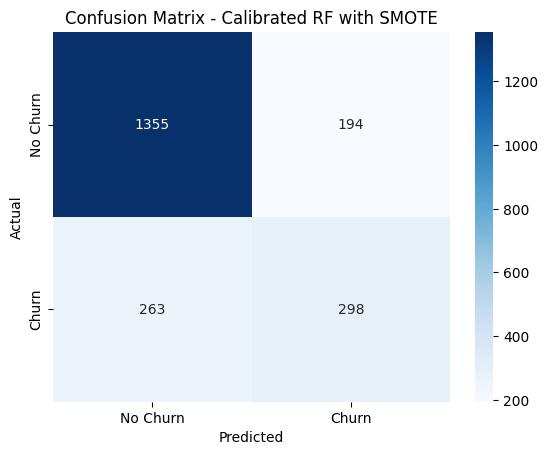

AUC Score: 0.8275749175190941


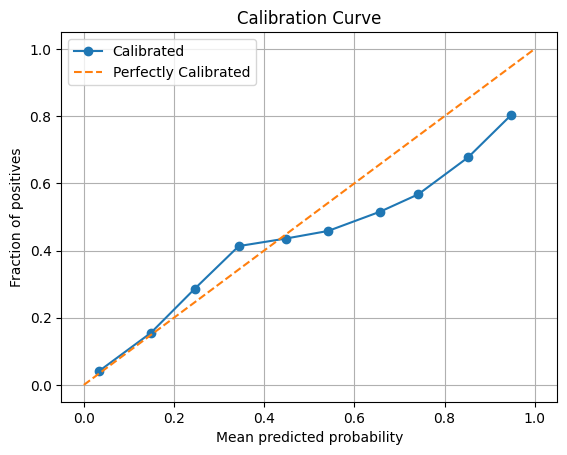

In [114]:
# Predict calibrated probabilities & labels
y_prob = calibrated_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Calibrated RF with SMOTE")
plt.show()

# AUC Score
print("AUC Score:", roc_auc_score(y_test, y_prob))

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()

In [115]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_sm, y_train_sm)
mi_df = pd.Series(mi_scores, index=X_train_sm.columns).sort_values(ascending=False)
top_features = mi_df.head(25).index.tolist()

X_train_sm = X_train_sm[top_features]
X_test = X_test[top_features]


In [117]:
from xgboost import XGBClassifier

xgb_top = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_top.fit(X_train_sm, y_train_sm)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:44:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1549
           1       0.50      0.78      0.61       561

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.80      0.74      0.75      2110

AUC Score: 0.8212721910173776


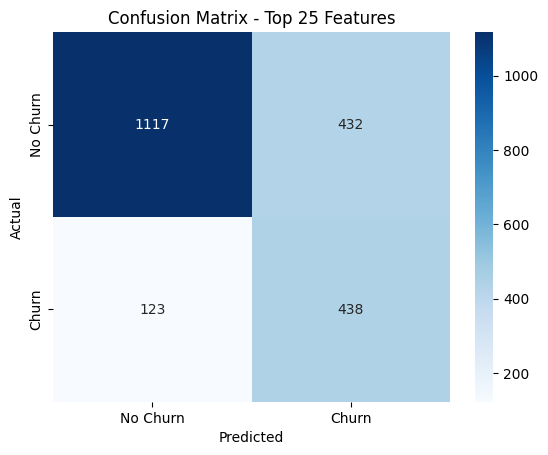

In [118]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = xgb_top.predict(X_test)
y_probs = xgb_top.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("AUC Score:", roc_auc_score(y_test, y_probs))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Top 25 Features")
plt.show()


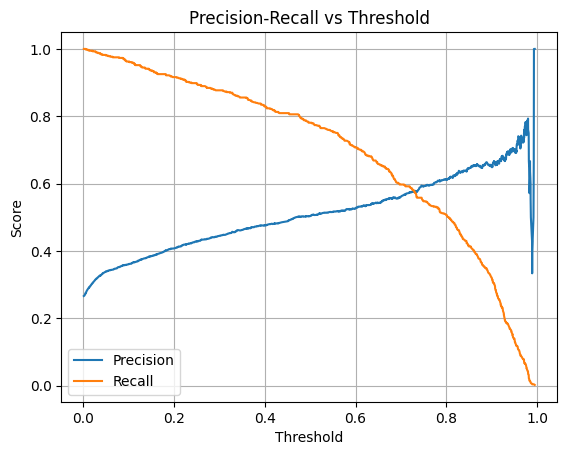

In [119]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_probs)

plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


In [123]:
X_train_sm.dtypes.value_counts()

X_train_sm.select_dtypes(include='object').columns.tolist()
X_train_sm = X_train_sm.astype(float)
X_test = X_test.astype(float)


 99%|===================| 2079/2110 [00:14<00:00]       

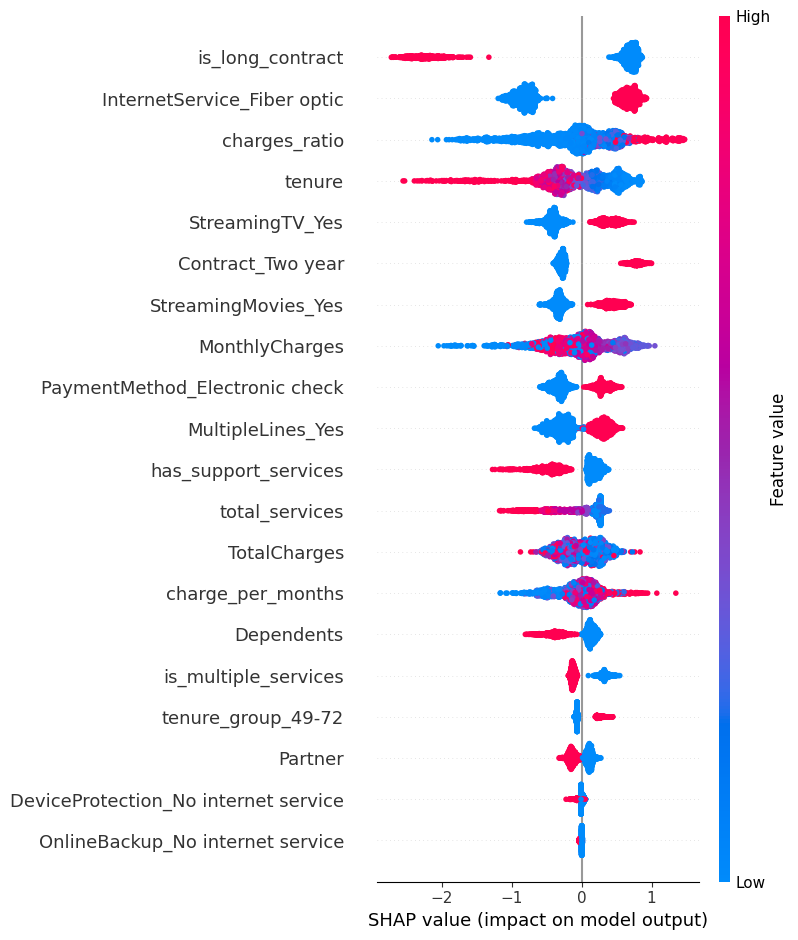

In [124]:
import shap
explainer = shap.Explainer(xgb_top, X_train_sm)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)
